In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt



pi = np.pi

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

class PointShapes:
    
    def __init__(self, 
                 num_points,
                 create_adj=False,
                 radius=1, 
                 batch_size=1):
        super(PointShapes, self).__init__()
        
        self.num_points = num_points
        assert self.num_points%4 == 0, "Num Points needs to be divisible by 4"
        
        self.radius = radius
        self.batch_size = batch_size
        self.create_adj = create_adj
        
        # generate dataset
        self.tf_dataset()
        
        self.training_dataset = self.dataset.shuffle(256).repeat().map(self.augment).batch(self.batch_size).prefetch(AUTOTUNE)
        
    def create_circle(self):
        n = self.num_points
        xy = [(self.radius*np.cos(x*2*pi/n), (self.radius*np.sin(x*2*pi/n))) for x in range(n)]
        
        return np.array(xy)
    
    def create_square(self):
        n = self.num_points//4 
        missing_points = self.num_points - n*4
        
        xy = [(self.radius*np.cos(x*2*pi/4 + pi/4), (self.radius*np.sin(x*2*pi/4 + pi/4))) for x in range(4)]
        square = np.concatenate([np.linspace(xy[i],xy[(i+1)%4],n) for i in range(4)])
        
        return square
    
    def rot_mat(self, data):
        """apply 2D roation"""
        assert data.shape[-1] == 2, 'data is not 2D'
        theta = np.radians(np.random.randint(0,360))
        rot = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
        
        return tf.matmul(data,rot)
    
    def trans_mat(self, data):
        """apply 2D translation"""
        assert data.shape[-1] == 2, 'data is not 2D'
        t = np.random.randint(-5,5)
        
        return data + np.array([[t,t]])
    
    def ref_mat(self, data):
        """apply 2D reflection"""
        assert data.shape[-1] ==2, 'data is not 2D'
        theta = np.radians(np.random.randint(0,360))
        ref = np.array([[np.cos(2*theta), np.sin(2*theta)],
                        [np.sin(2*theta), -np.cos(2*theta)]])
        return tf.matmul(data,ref)
    
    def shapeGenerator(self):
        coords_list = [self.create_circle(), self.create_square()]
        labels = ['circle', 'square']
        label_list = [[0,1], [1,0]]

        coords = tf.stack(coords_list, axis=0)
        ids = tf.stack(label_list, axis=0)

        return coords, labels, ids

    def tf_dataset(self):
        coords, labels, ids = self.shapeGenerator()

        features = tf.ones((2, self.num_points, 1))
        
        if self.create_adj:
            adj = coord_to_adj(coords)
            binary_adj = adj_to_binary(adj)
            
            dataset = tf.data.Dataset.from_tensor_slices(
                ({'adj': binary_adj,
                  'coords': coords,
                  'features': features},
                 {'labels': ids}))
        else:
            dataset = tf.data.Dataset.from_tensor_slices(
                ({'coords':coords,
                  'features': features},
                 {'labels': ids}))
        
        self.dataset = dataset
        
    def augment(self, *args):
        X_data = args[0]
        y_data = args[1]

        X = X_data['coords']

        X = self.rot_mat(X)
        X = self.trans_mat(X)
        X = self.ref_mat(X)

        X_data['coords'] = X

        return (X_data, y_data)

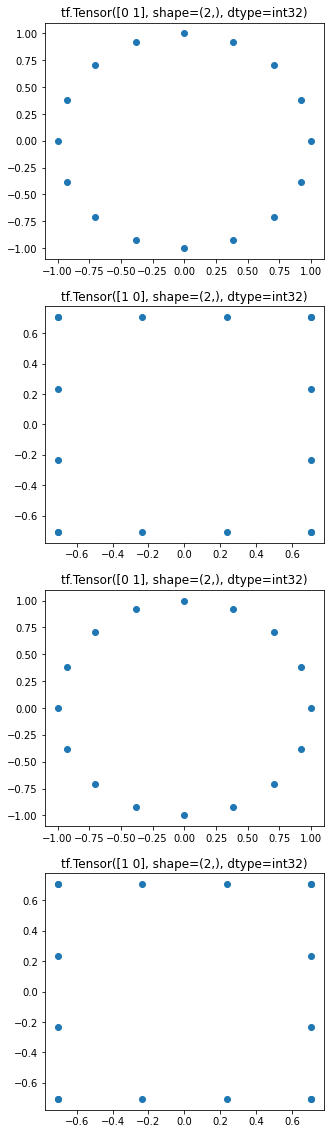

In [3]:
fig, axes = plt.subplots(4,1,figsize=(5, 20))
ps = PointShapes(16, radius=1, batch_size=1)
it = iter(ps.dataset.repeat().batch(1))
for i in range(4):
    X_data, y_data = next(it)
    X = X_data['coords']
    y = y_data['labels']
    axes[i].scatter(X[0,...,0], X[0,...,1])
    axes[i].set_title(str(y[0]))

In [4]:
shape = PointShapes(100)

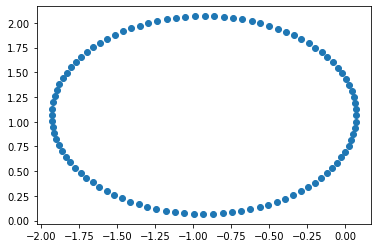

In [5]:
data = next(shape.training_dataset.as_numpy_iterator())[0]['coords']
sdata = np.squeeze(data)
x,y = zip(*sdata)
plt.scatter(x,y)

In [6]:

from tensorflow.keras import Model, Input
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer, Activation, Dense, Softmax
from tensorflow.keras.layers import BatchNormalization, Flatten, Lambda

class PointConvolution(Layer):
    def __init__(self, 
                 output_dim=64,
                 **kwargs):
        super(PointConvolution, self).__init__(**kwargs)
        
        self.output_dim = output_dim

        # Define radial layers
        radial_dict = {}
        radial_dict['dense_0'] = Dense(self.output_dim)
        radial_dict['bn_0'] = BatchNormalization(axis=-1)
        radial_dict['dense_1'] = Dense(self.output_dim)
        radial_dict['bn_1'] = BatchNormalization(axis=-1)
        radial_dict['dense_2'] = Dense(1)
        self.radial_dict = radial_dict

        # Define features layers
        feature_dict = {}
        feature_dict['dense_0'] = Dense(self.output_dim)
        feature_dict['bn_0'] = BatchNormalization(axis=-1)
        feature_dict['dense_1'] = Dense(self.output_dim)
        feature_dict['bn_1'] = BatchNormalization(axis=-1)
        self.feature_dict = feature_dict
        
    def _l2_norm(self, r):
        """
        Compute L2 norm of a coordinate vector
        r - (batch, points, 2)
        """
        x = r[...,0]
        y = r[...,1]
        
        output = tf.sqrt(x**2 + y**2)
        
        return output
    
    
    def _cdist(self, r):
        """
        Compute all pairwise distances
        r - (batch, points, 2)
        """
        r_0 = tf.expand_dims(r, axis=2)
        multiples = [1,1, tf.shape(r)[1], 1]
        r_0 = tf.tile(r_0, multiples)
        
        r_1 = tf.expand_dims(r, axis=1)
        multiples = [1, tf.shape(r)[1], 1, 1]
        r_1 = tf.tile(r_1, multiples)
        
        output = r_0 - r_1
        return output
    
    def call(self, inputs):
        # Get inputs
        # inputs[0] - coordinates - (batch, points, 2)
        # inputs[1] - fetaures - (batch, points, channels)
        
        r = inputs[0]
        x = inputs[1]
        
        # Compute the coordinate component
        r_ij = self._cdist(r) # (batch, points, points, 2)
        r_ij = self._l2_norm(r_ij) # (batch, points, points)
        r_ij = tf.expand_dims(r_ij, axis=-1) # (batch, points, points, 1)
        
        radial = self.radial_dict
        R = radial['dense_0'](r_ij) # (batch, points, points, 64)
#         R = radial['bn_0'](R)
        R = Activation('relu')(R)
        R = radial['dense_1'](R)
#         R = radial['bn_1'](R)
        R = Activation('relu')(R)
        R = radial['dense_2'](R) # (batch, points, points, 1)
        R = tf.squeeze(R, axis=-1)
        
        # Compute the feature component
        feature = self.feature_dict
        X = feature['dense_0'](x) # (batch, points, c)
#         X = feature['bn_0'](X)
        X = Activation('relu')(X)
        X = feature['dense_1'](X)
        # X = Activation('relu')(X)
#         X = feature['bn_1'](X) # (batch, points, 64)
        # Perform point convolution
        output = tf.matmul(R, X)
        
        return output

In [7]:
NUM_POINTS = 100
def point_model():
    r = Input(shape= (NUM_POINTS,2),name='coords')
    x = Input(shape= (NUM_POINTS,1),name='features')
    inputs = (r,x)
    
    x = PointConvolution()(inputs)
    x = Activation('relu')(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = Dense(2)(x)
    x = Softmax(axis=-1, name='labels')(x)
    
    return Model(inputs=inputs, outputs=x)

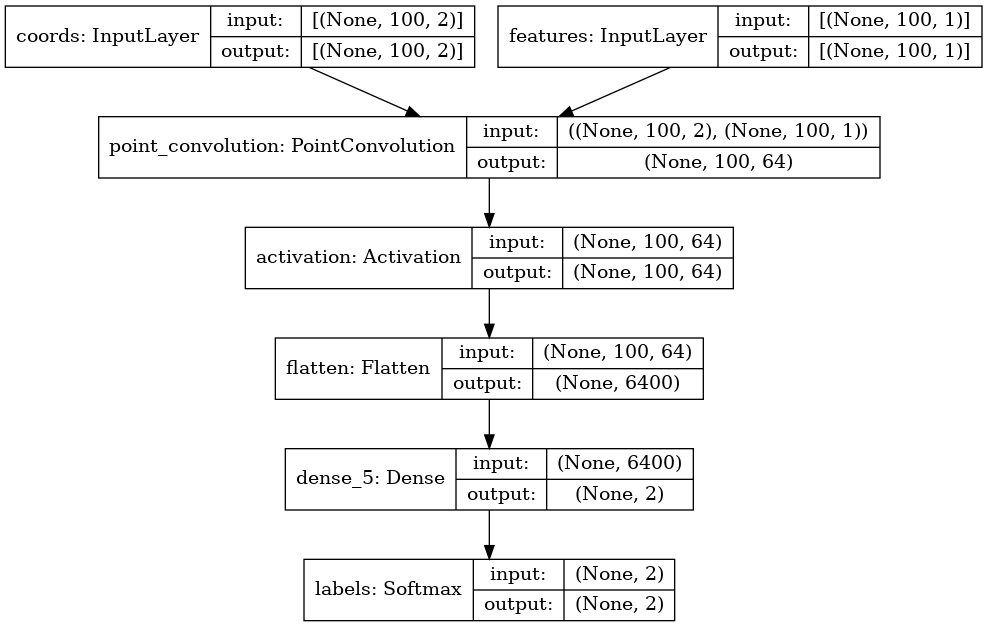

In [8]:
model = point_model()
plot_model(model, show_shapes=True)

In [9]:
optimizer = Adam(learning_rate=1e-3)
losses = {'labels': tf.keras.losses.categorical_crossentropy}
metrics = {'labels': ['accuracy']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

In [10]:
model.fit(PointShapes(NUM_POINTS).training_dataset,
          epochs=10,
          steps_per_epoch=128,
          batch_size=1)

Epoch 1/10
128/128 [==============================] - 2s 5ms/step - loss: 1.4617 - accuracy: 0.3708
Epoch 2/10
128/128 [==============================] - 1s 6ms/step - loss: 0.4676 - accuracy: 0.7991
Epoch 3/10
128/128 [==============================] - 1s 6ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 4/10
128/128 [==============================] - 1s 6ms/step - loss: 6.6316e-04 - accuracy: 1.0000
Epoch 5/10
128/128 [==============================] - 1s 6ms/step - loss: 3.5459e-04 - accuracy: 1.0000
Epoch 6/10
128/128 [==============================] - 1s 6ms/step - loss: 2.2321e-04 - accuracy: 1.0000
Epoch 7/10
128/128 [==============================] - 1s 6ms/step - loss: 1.5244e-04 - accuracy: 1.0000
Epoch 8/10
128/128 [==============================] - 1s 6ms/step - loss: 1.1202e-04 - accuracy: 1.0000
Epoch 9/10
128/128 [==============================] - 1s 6ms/step - loss: 8.4344e-05 - accuracy: 1.0000
Epoch 10/10
128/128 [==============================] - 1s 6ms/step - loss: 6

In [11]:
it = iter(PointShapes(NUM_POINTS).training_dataset)

for i in range(16):
    X_data, y_data = next(it)
    print(y_data['labels'])
    print(model.predict(X_data))
    print()

tf.Tensor([[0 1]], shape=(1, 2), dtype=int32)
[[7.466958e-05 9.999254e-01]]

tf.Tensor([[1 0]], shape=(1, 2), dtype=int32)
[[9.9996340e-01 3.6548106e-05]]

tf.Tensor([[0 1]], shape=(1, 2), dtype=int32)
[[7.466958e-05 9.999254e-01]]

tf.Tensor([[1 0]], shape=(1, 2), dtype=int32)
[[9.9996340e-01 3.6548106e-05]]

tf.Tensor([[1 0]], shape=(1, 2), dtype=int32)
[[9.9996340e-01 3.6548106e-05]]

tf.Tensor([[0 1]], shape=(1, 2), dtype=int32)
[[7.466958e-05 9.999254e-01]]

tf.Tensor([[1 0]], shape=(1, 2), dtype=int32)
[[9.9996340e-01 3.6548106e-05]]

tf.Tensor([[0 1]], shape=(1, 2), dtype=int32)
[[7.466958e-05 9.999254e-01]]

tf.Tensor([[1 0]], shape=(1, 2), dtype=int32)
[[9.9996340e-01 3.6548106e-05]]

tf.Tensor([[0 1]], shape=(1, 2), dtype=int32)
[[7.466958e-05 9.999254e-01]]

tf.Tensor([[0 1]], shape=(1, 2), dtype=int32)
[[7.466958e-05 9.999254e-01]]

tf.Tensor([[1 0]], shape=(1, 2), dtype=int32)
[[9.9996340e-01 3.6548106e-05]]

tf.Tensor([[0 1]], shape=(1, 2), dtype=int32)
[[7.466958e-05 9.9

In [12]:
def coord_to_adj(point_coords):
    """
    takes a list of points and outputs an dist matrix between points
    
    input: ndarray or tf.Tensor of shape (batch, n_points, 2)
    output: tf.Tensor shape (batch, n_points, n_points)
    """
    
    r_0 = tf.expand_dims(point_coords, axis=2)
    multiples = [1,1, tf.shape(point_coords)[1], 1]
    r_0 = tf.tile(r_0, multiples)

    r_1 = tf.expand_dims(point_coords, axis=1)
    multiples = [1, tf.shape(point_coords)[1], 1, 1]
    r_1 = tf.tile(r_1, multiples)

    output = tf.cast(r_0 - r_1, tf.float32)

    x = output[...,0]
    y = output[...,1]

    dist = tf.sqrt(tf.square(x) + tf.square(y))

    return dist

In [13]:
def adj_to_binary(adj_mat, threshold=1.):
    """
    threshold is what percent of the mean distance do you want to consider a neighboor
    """
    
    mean_dist = tf.reduce_mean(adj_mat)
    cutoff = threshold*mean_dist
    
    return tf.cast(adj_mat > cutoff, tf.float32)

## Test GAT

In [14]:
N = NUM_POINTS = 16

it = iter(PointShapes(NUM_POINTS, create_adj=True).training_dataset)

tf.Tensor(
[[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]]], shape=(1, 16, 16), dtype=float32)


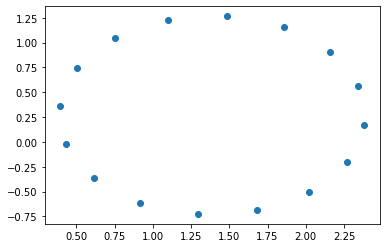

In [15]:
X_data, y_data = next(it)
adj = X_data['adj']
X = X_data['coords']
y = y_data['labels']
print(adj)
plt.scatter(X[0,...,0], X[0,...,1])

In [16]:
# Parameters
channels = 8  # Number of channels in each head of the first GAT layer
n_attn_heads = 8  # Number of attention heads in first GAT layer
dropout = 0.6  # Dropout rate for the features and adjacency matrix
l2_reg = 2.5e-4  # L2 regularization rate
learning_rate = 5e-3  # Learning rate
epochs = 20000  # Number of training epochs
patience = 100  # Patience for early stopping

In [17]:
N = 16  # Number of nodes in the graph
F = 2  # Original size of node features
n_out = 1  # Number of classes

print(N, F, n_out)

16 2 1


In [18]:

# Model definition
x_in = Input(shape=(N,F,), name='coords')
a_in = Input((N,N,), sparse=True, name='adj')

do_1 = Dropout(dropout)(x_in)

gc_1 = GATConv(
    channels,
    attn_heads=n_attn_heads,
    concat_heads=True,
    dropout_rate=dropout,
    activation="elu",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_1, a_in])

do_2 = Dropout(dropout)(gc_1)

gc_2 = GATConv(
    channels,
    attn_heads=1,
    concat_heads=False,
    dropout_rate=dropout,
    activation="softmax",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_2, a_in])

x = Flatten()(gc_2)
x = Dense(2)(x)
out = Softmax(axis=-1, name ='labels')(x)


# Build model
model = Model(inputs=[x_in, a_in], outputs=out)
optimizer = Adam(lr=learning_rate)

model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)
model.summary()

NameError: name 'Dropout' is not defined

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.fit(PointShapes(NUM_POINTS, create_adj=True).training_dataset,
          epochs=10,
          steps_per_epoch=128,
          batch_size=32)

## EGNN

In [ ]:
import einops
einops.__version__

In [ ]:
!pip install einops

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer, Activation, Dense

In [ ]:
class egcl(Layer):
    def __init__(self, dim, edge_dim=0, m_dim=16, **kwargs):
        super(egcl, self).__init__(**kwargs)
        
        edge_input_dim = dim*2 + edge_dim + 1
        
        self.edge_func = tf.keras.Sequential([Dense(edge_input_dim*2),
                                               Activation('swish'),
                                               Dense(m_dim),
                                               Activation('swish')
                                              ])
        
        self.coord_func = tf.keras.Sequential([Dense(m_dim*4),
                                               Activation('swish'),
                                               Dense(1)
                                              ])
        
        self.node_func = tf.keras.Sequential([Dense(dim*2),
                                              Activation('swish'),
                                              Dense(dim)
                                             ])
        
        
    def call(self, coords, feats, edges=None):
        b, n, d = feats.shape
        
        rel_coords = rearrange(coords, 'b i d -> b i () d') - rearrange(coords, 'b  j d -> b () j d')
#         print(rel_coords)
        rel_dist = tf.reduce_sum((rel_coords ** 2), axis=-1, keepdims=True)
        
        feats_i = repeat(feats, 'b i d -> b i n d', n=n)
        feats_j = repeat(feats, 'b j d -> b n j d', n=n)
        
        edge_input = tf.concat([feats_i, feats_j, rel_dist], axis=-1)
        
        print(edge_input.shape)
        print(edges.shape)
        
        if edges is not None:
            edges = tf.expand_dims(edges, axis=-1)
            edge_input = tf.concat([edge_input, edges], axis=-1)
        
        m_ij = self.edge_func(edge_input)
        
        coord_weights = self.coord_func(m_ij)
        coord_weights = rearrange(coord_weights, 'b i j () -> b i j')
        
        coords_out = tf.einsum('b i j, b i j c -> b i c', coord_weights, rel_coords) + coords
        
        m_i = tf.reduce_sum(m_ij, axis=-2)
        
        node_input = tf.concat([feats, m_i], axis=-1)
        node_out = self.node_func(node_input) + feats
        
        return coords_out, node_out

In [ ]:
NUM_POINTS = 100
def point_model():
    r = Input(shape= (NUM_POINTS,2),name='coords')
    x = Input(shape= (NUM_POINTS,1),name='features')
    
    
    r, x = egcl(64)(r, x)
    x = Activation('relu')(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = Dense(2)(x)
    x = Softmax(axis=-1, name='labels')(x)
    
    return Model(inputs=inputs, outputs=x)

In [ ]:
layer1 = egcl(1)
layer2 = egcl(2)

In [ ]:
r = Input(shape= (NUM_POINTS,2),name='coords')
x = Input(shape= (NUM_POINTS,1),name='features')
inputs = (r,x)

In [ ]:
out = layer1(X_data['coords'], X_data['features'])

In [ ]:
out[0]

In [ ]:
out[1]

In [ ]:
import networkx as nx

In [ ]:
from networkx.generators.random_graphs import gnp_random_graph
from networkx.linalg import graphmatrix

In [ ]:
def tf_dataset():
    n_nodes = np.random.randint(7,17)
    g = gnp_random_graph(n_nodes,.25,seed=42)
    adj = nx.to_numpy_array(g)

    adj = tf.expand_dims(adj, axis=0)
    coords = tf.random.normal(shape=(1,n_nodes,8))

    feats = tf.ones((1,n_nodes,1))

    dataset = tf.data.Dataset.from_tensor_slices(
        ({'adj': adj,
          'coords': coords,
          'feats': feats},
         {'true_adj': adj}))

    return dataset

In [ ]:
tf_dataset().repeat().batch(1)

In [ ]:
class decoder(Layer):
    def __init__(self):
        super(decoder, self).__init__()
      
        
        def build(self, input_shape):
            self.w = self.add_weight(shape=(int(input_shape[-1]),
                                                input_shape[1]))
            
            self.b = self.add_weight(shape=(input_shape[1]))
            
        def call(self, inputs):
            rel_coords = rearrange(inputs, 'b i d -> b i () d') - rearrange(inputs, 'b j d -> b () j d')
            rel_dist = tf.reduce_sum((rel_coords ** 2), axis=-1, keepdims=True)
            
            decoded = tf.exp(tf.matmul(rel_dist, self.w) + self.b)
            
            return decoded
                
    
    


In [ ]:

def egnn_model():
    adj = Input(shape=(n_nodes, n_nodes), name='adj')
    coords = Input(shape=(n_nodes, 8), name='coords')
    feats = Input(shape=(n_nodes,1), name='feats')
    
    x, h = egcl(64)(coords, feats, adj)
    x, h = egcl(64)(x, h, adj)
    
    decoded = decoder()(x)
    out = Activation('sigmoid', name='true_adj')(-decoded)
    
    return Model(inputs=[coords, feats, adj], outputs=out)

In [ ]:
model = egnn_model()
plot_model(model, show_shapes=True)

In [ ]:
n_nodes=14
coords = tf.random.normal(shape=(1,n_nodes,16))
coords = tf.repeat(coords, 100, axis=0)

feats = tf.ones((100,n_nodes,1))

graphs = []
for i in range(100):
    g = gnp_random_graph(n_nodes,.25,seed=None)
    adj = nx.to_numpy_array(g)

    graphs.append(adj)

adj_data = tf.stack(graphs, axis=0)

dataset = tf.data.Dataset.from_tensor_slices(
        ({'adj': adj_data,
          'coords': coords,
          'feats': feats},
         {'decoder': adj_data}))

dataset

In [ ]:
feats = tf.reshape(tf.range(6), (2,3,1))
feats

In [ ]:
repeat(feats, 'b i d -> b i n d', n=3) 

In [ ]:
repeat(feats, 'b j d -> b n j d', n=3) 

In [ ]:
tmp = tf.concat([repeat(feats, 'b i d -> b i n d', n=3) , repeat(feats, 'b j d -> b n j d', n=3) ], axis=-1)

In [ ]:
coords = tf.random.normal(shape=(1,3,4))
coords = tf.repeat(coords, 2, axis=0)
coords

In [ ]:
rel_coords = rearrange(coords, 'b i d -> b i () d') - rearrange(coords, 'b  j d -> b () j d')
rel_coords

In [ ]:
rel_dist = tf.reduce_sum((rel_coords ** 2), axis=-1, keepdims=True)
rel_dist

In [ ]:
tmp

In [ ]:
tmp = tf.concat([tf.cast(repeat(feats, 'b i d -> b i n d', n=3), 'float32'), 
           tf.cast(repeat(feats, 'b j d -> b n j d', n=3), 'float32'), 
           rel_dist], axis=-1)

In [ ]:
graphs = []
for i in range(2):
    g = gnp_random_graph(3,.25,seed=None)
    adj = nx.to_numpy_array(g)

    graphs.append(adj)

adj_data = tf.stack(graphs, axis=0)

In [ ]:
adj = tf.expand_dims(adj_data, axis=-1)
adj

In [ ]:
edge_input = tf.concat([tmp, tf.cast(adj, 'float32')], axis=-1)

In [ ]:
edge_input

In [ ]:
tmp